# Project 4: Advanced Lane Finding

## Overview
In this project we would improve our technique for finding road lanes and curvature of the lanes. In order to do this, we would use a series of steps, outlined below:

1. Camera Calibration
2. Distortion Correction
3. Color and Gradient Thresholds
4. Perspective Transform
5. Detect Lane Lines
6. Determine Lane Curvature
7. Apply these techniques to the frames of the video

We will proceed step by step, showing partial results (on frames/images from video) along the way, to see how each step is helping achieve our ultimate goal.

In [1]:
# Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

## 2. Distortion Correction

Now that we calculated the camera matrix in the other notebook, we will conveniently load the parameters here from the *pickled* file. 

In [2]:
calibration_params_file = 'dist_pickle.p'

with open(calibration_params_file, 'rb') as f:
    calibration_params = pickle.load(f)

mtx = calibration_params["mtx"]
dist = calibration_params["dist"]

Now let's test and see that the params are correct.

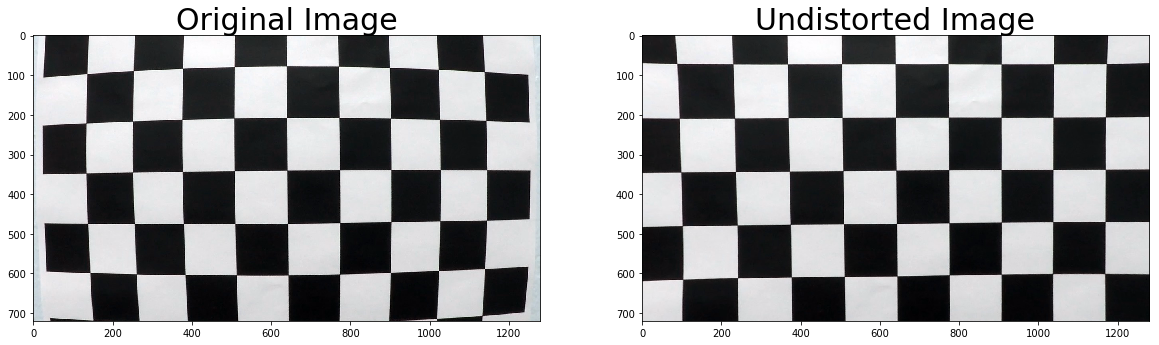

In [3]:
%matplotlib inline

img = cv2.imread('camera_cal/calibration1.jpg')
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

#Display a comparison between the distorted and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

Ok! Seems like our parameters were properly saved in the *pickled* file and we properly restored them from there. Before we move on to the next steps, let's just make a helper function that will undistort a given image.

In [4]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## 4. Perspective Transform

In order to perform *perspective transform*, we need to find a rectangle that covers our lane lines in most of the situations, define that rectangle with 4 points on the image, and then warp those. Also, something to note is that we will first need to *undistort* our images first, in order to preserve the correct shapes of the objects (lines) from the source image.

In [6]:
test_img = mpimg.imread('test_images/straight_lines1.jpg')
test_img_size = (test_img.shape[1], test_img.shape[0])

x1, y1 = (500, 480)
x2, y2 = (780, 480)
x3, y3 = (1200, 670)
x4, y4 = (80, 670)

src = np.float32(
    [[x1, y1],
     [x2, y2],
     [x3, y3],
     [x4, y4]])

offset = 10
dst = np.float32(
    [[offset, offset],
     [test_img_size[0] - offset, offset],
     [test_img_size[0] - offset, test_img_size[1] - offset],
     [offset, test_img_size[1] - offset]])

M = cv2.getPerspectiveTransform(src, dst)

In [7]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    img = undistort(img)
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img

## 3. Color and Gradient Thresholds

Now we move on to applying some different color spaces and gradient thresholds to the images.

In [9]:
os.listdir("test_images/")

['challenge_lines1.jpg',
 'challenge_lines2.jpg',
 'harder_challenge_lines1.jpg',
 'harder_challenge_lines2.jpg',
 'harder_challenge_lines3.jpg',
 'harder_challenge_lines4.jpg',
 'harder_challenge_lines5.jpg',
 'harder_challenge_lines6.jpg',
 'harder_challenge_lines7.jpg',
 'harder_challenge_lines8.jpg',
 'straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

Let's see how the HSV and HLS color spaces behave on some of the test images that we have.

After seeing some of the examples, it is clear that the **Saturation** channels from HSV and HLS are different and produce different results. That being said, it seems like the **HLS Saturation** and **HSV Value** channels are the ones that produce the most consistent results in terms of highlighting the lines. Therefore, we will move on with some thresholding experiments on them.

In [11]:
def line_color_filter(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    
    yellow_mask = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([40, 255, 255]))
    white_mask = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([255, 255, 255]))
    
    return cv2.bitwise_and(warped_img, warped_img, mask= white_mask | yellow_mask)

We will define the three types of sobel gradients here, and later combine them together. All of the sobel helpers will receive as an input a 1 channel image (most likely one of the HSVor HLS channels).

In [16]:
def abs_sobel_thresh(img_channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel = np.zeros(img_channel.shape)
    
    if orient == 'x':
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output   

In [17]:
def mag_sobel_thresh(img_channel, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magn_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * magn_sobel / np.max(magn_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [18]:
def dir_sobel_thresh(img_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(gradient_direction)
    binary_output[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1

    return binary_output

In [12]:
def lines_preprocessing(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    copy = np.copy(img)
    
    # Convert image to both HSV and HLS as described above
    hsv = cv2.cvtColor(copy, cv2.COLOR_RGB2HSV).astype(np.float)
    hls = cv2.cvtColor(copy, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Grab the HLS Saturation channel
    s_channel = hls[:,:,2]
    # Grab the HSV Value channel
    v_channel = hsv[:,:,2]
    
    # Sobel x because we want to emphasize the edges closer to vertical (which are our lane lines)
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Taking the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold Saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

challenge_lines1.jpg


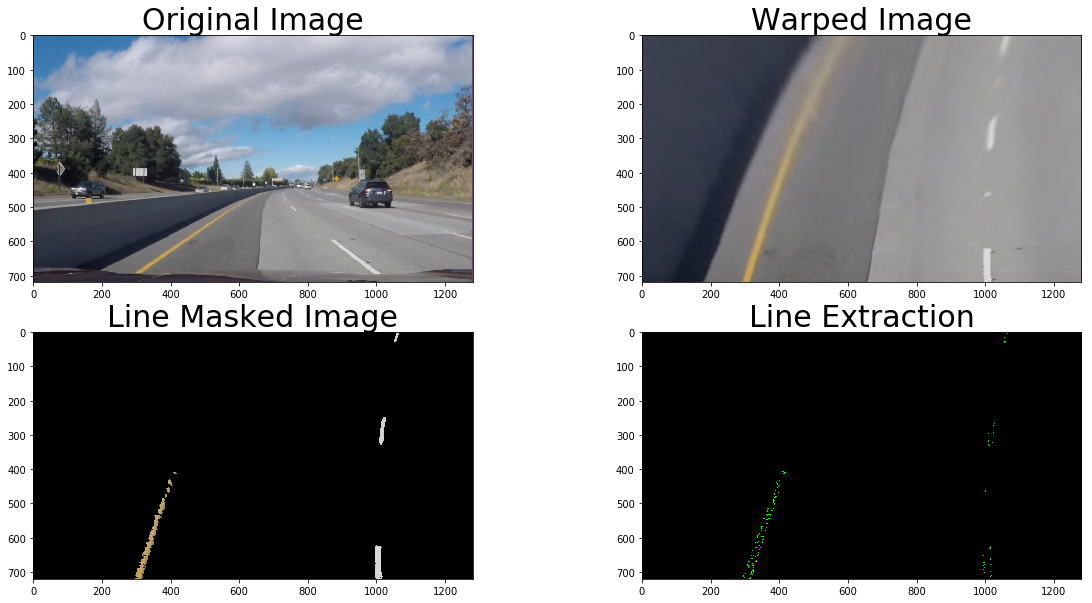

challenge_lines2.jpg


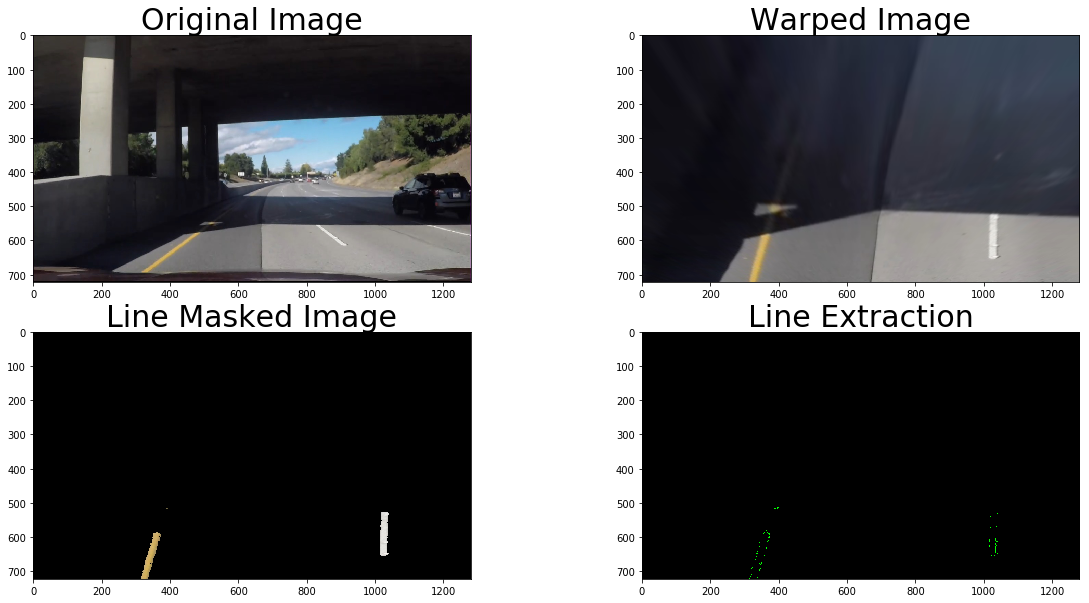

harder_challenge_lines1.jpg


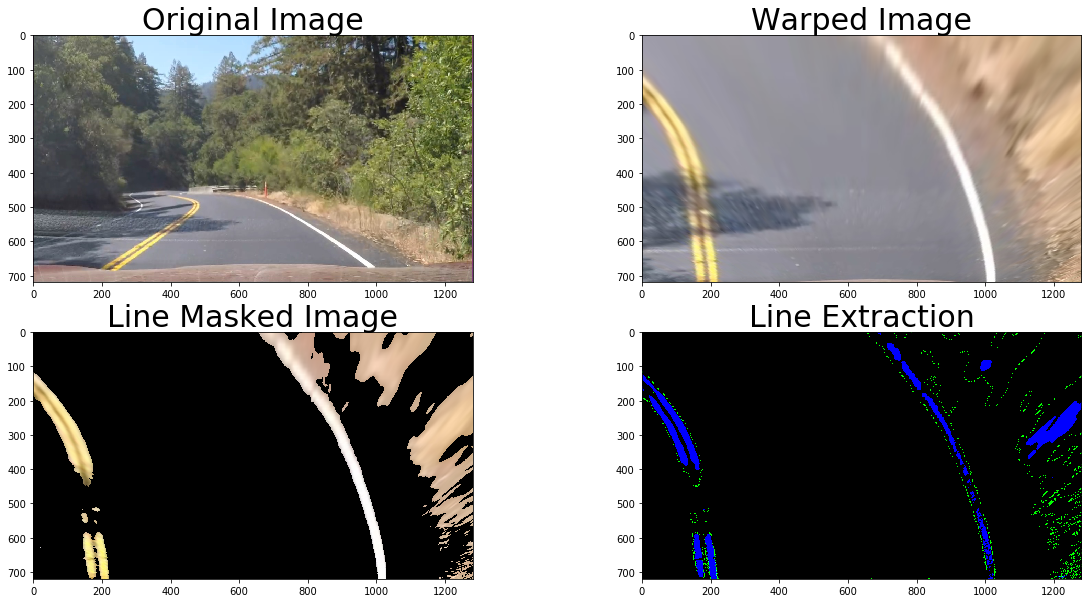

harder_challenge_lines2.jpg


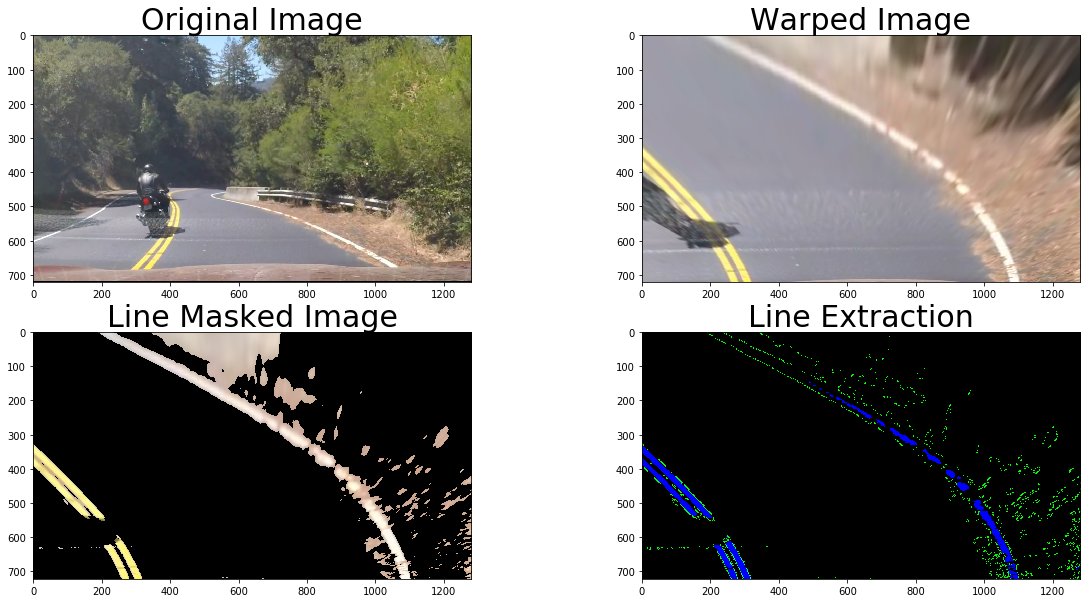

harder_challenge_lines3.jpg


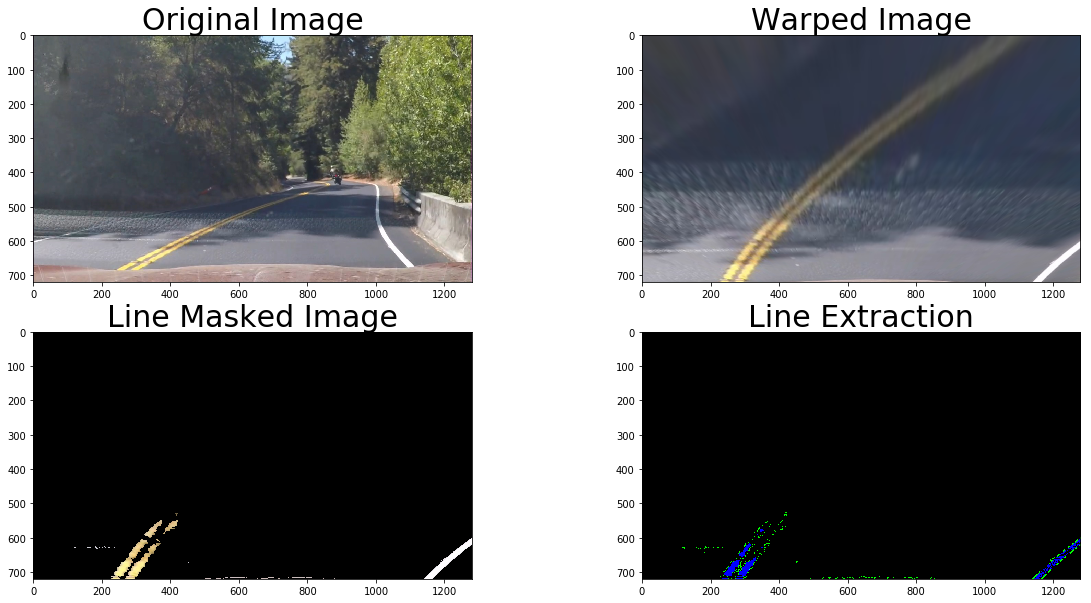

harder_challenge_lines4.jpg


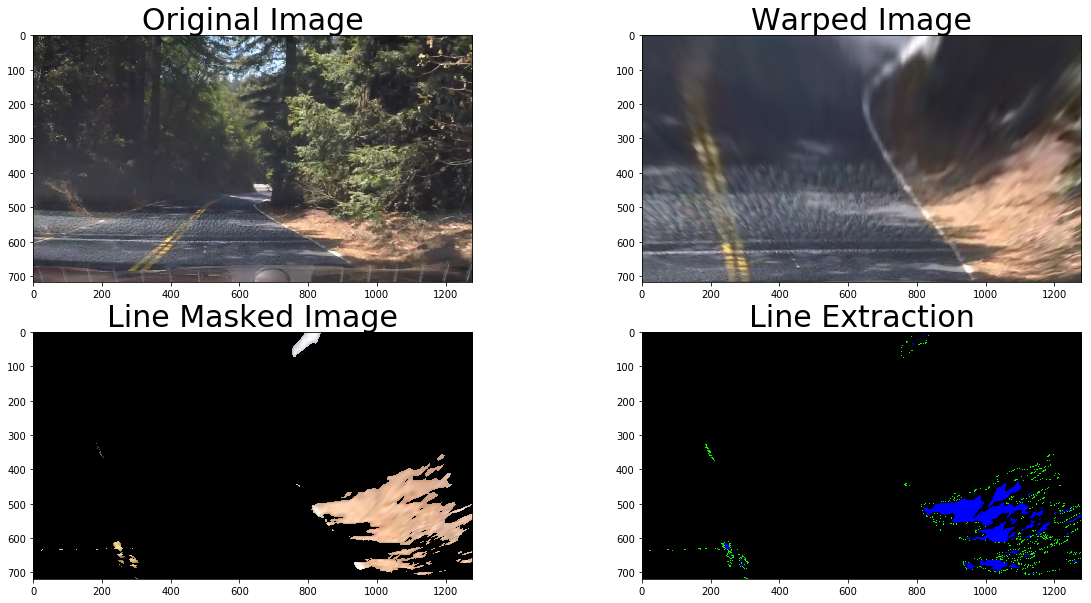

harder_challenge_lines5.jpg


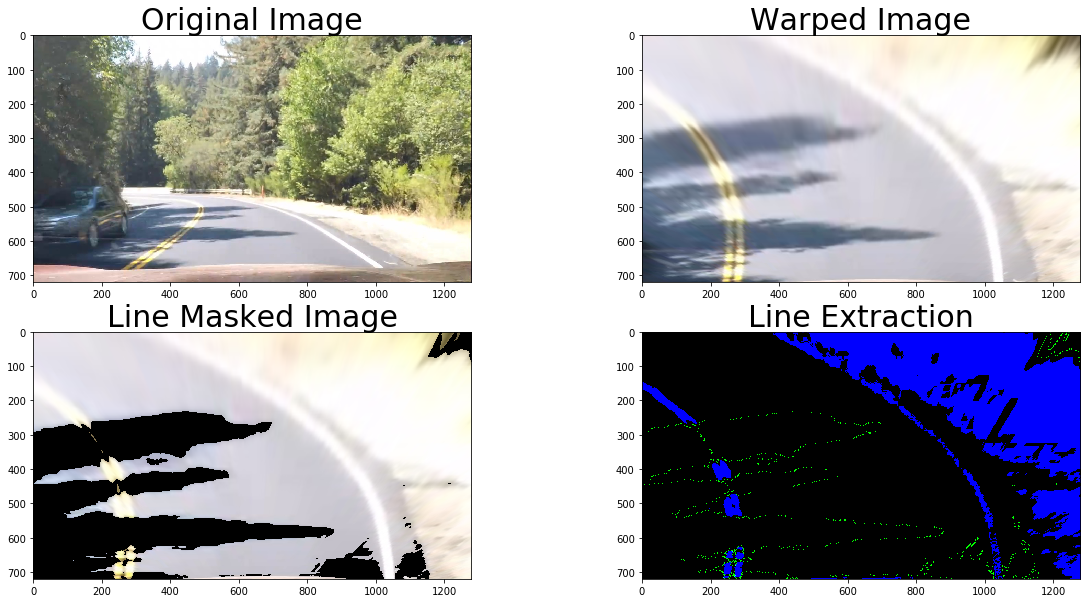

harder_challenge_lines6.jpg


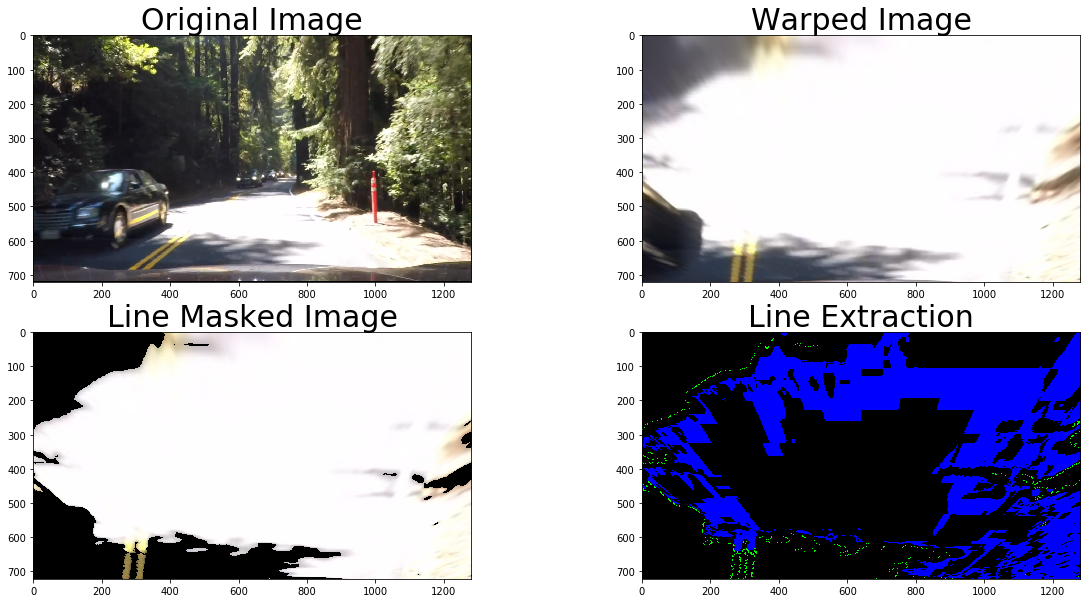

harder_challenge_lines7.jpg


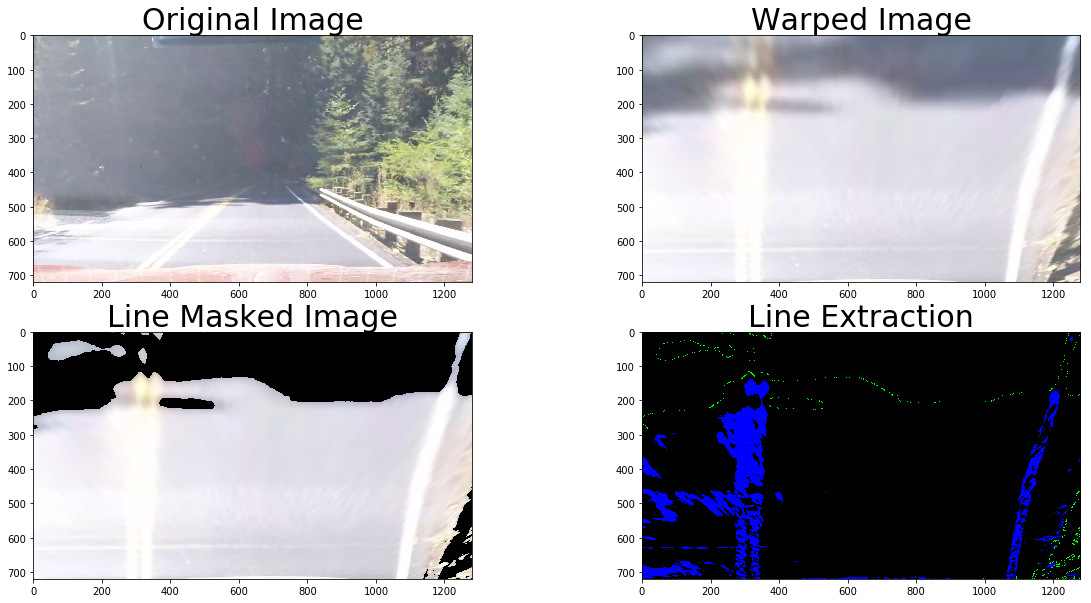

harder_challenge_lines8.jpg


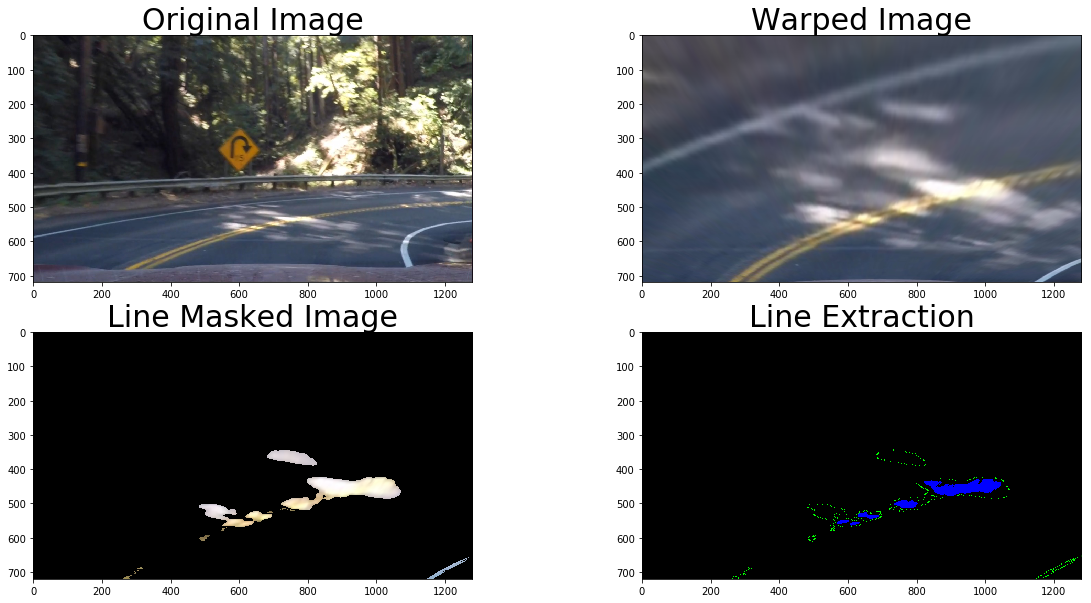

straight_lines1.jpg


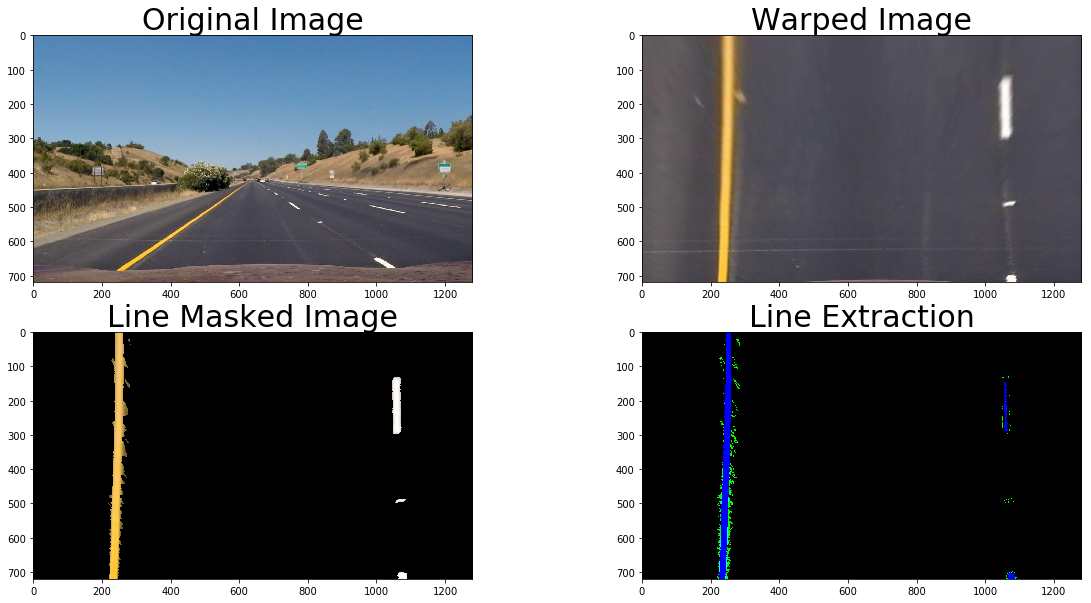

straight_lines2.jpg


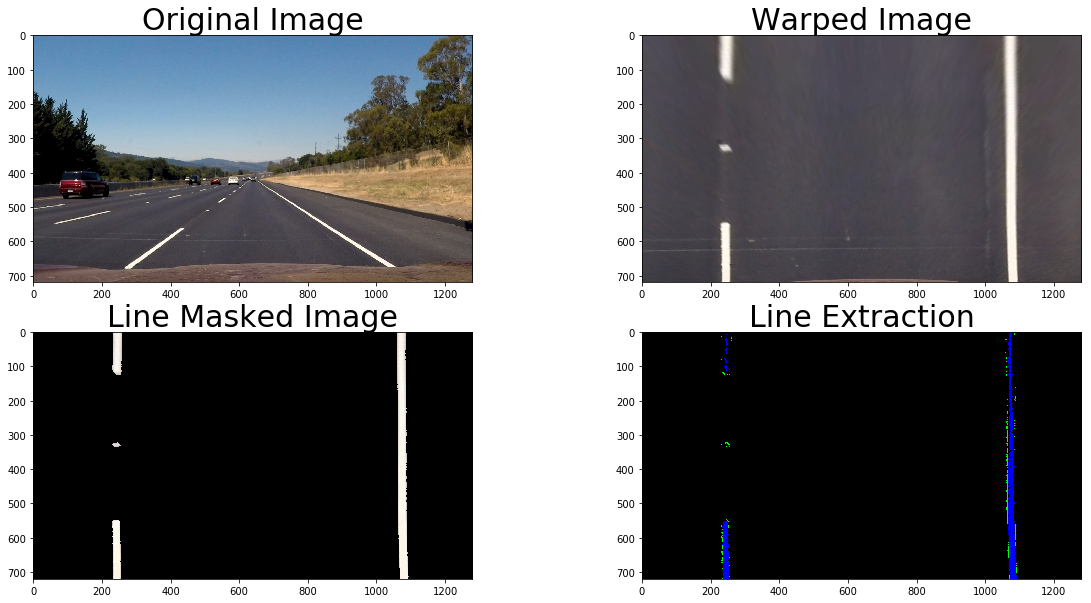

test1.jpg


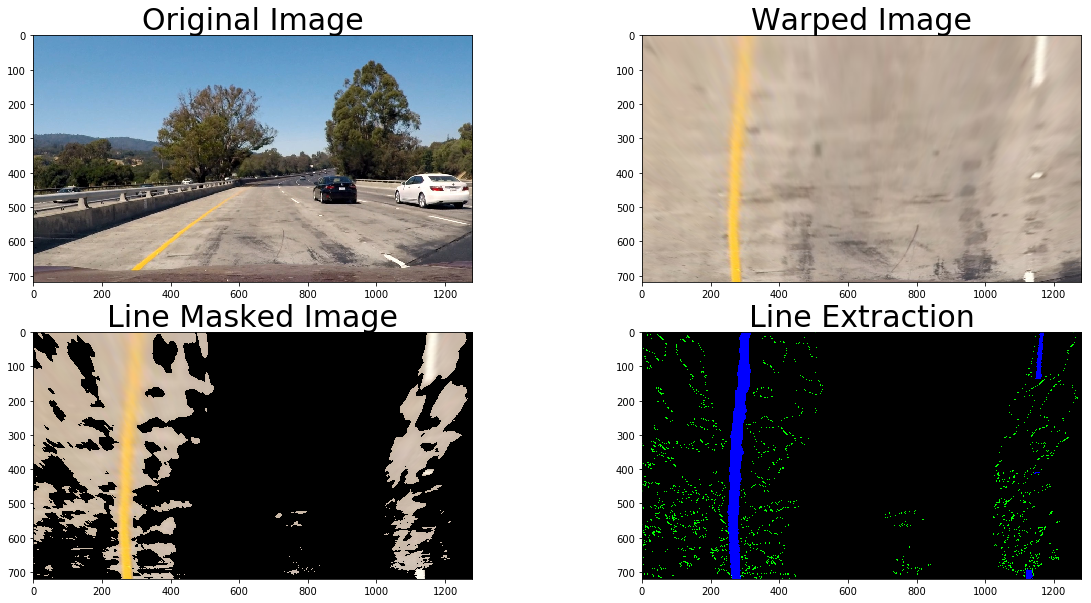

test2.jpg


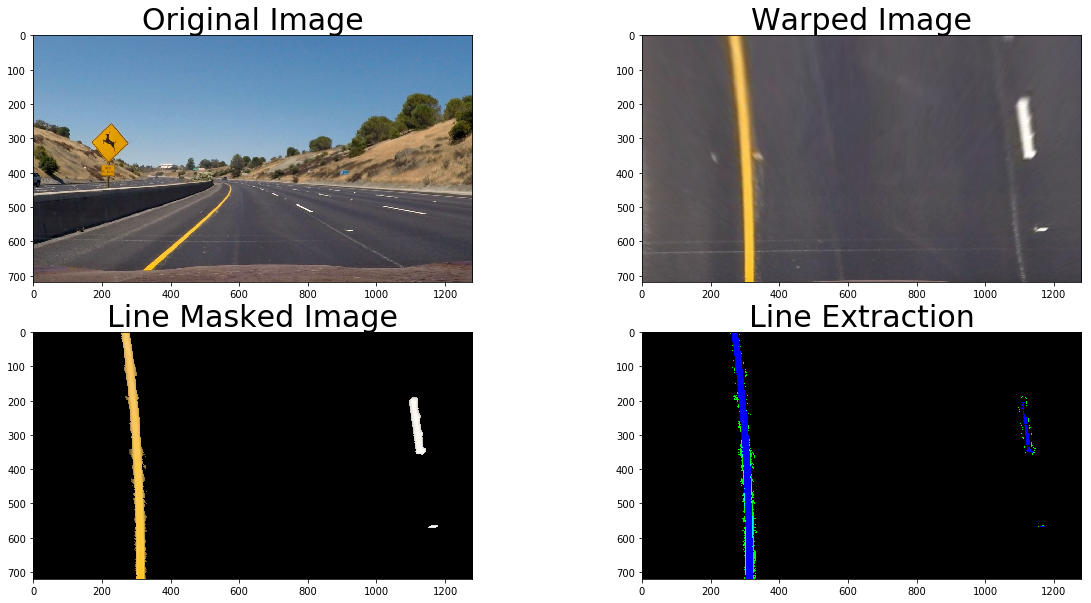

test3.jpg


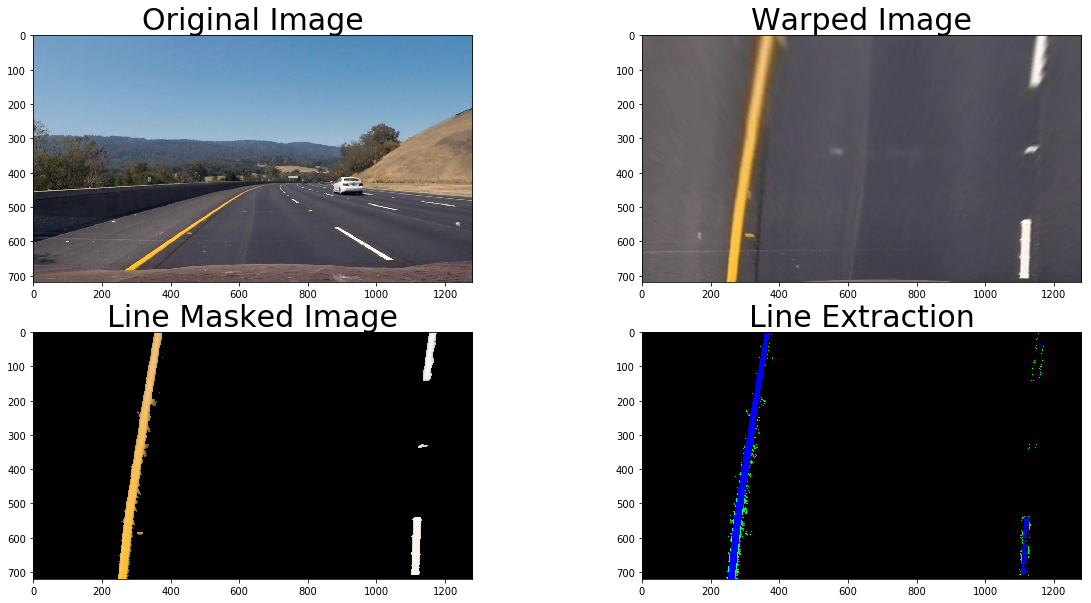

test4.jpg


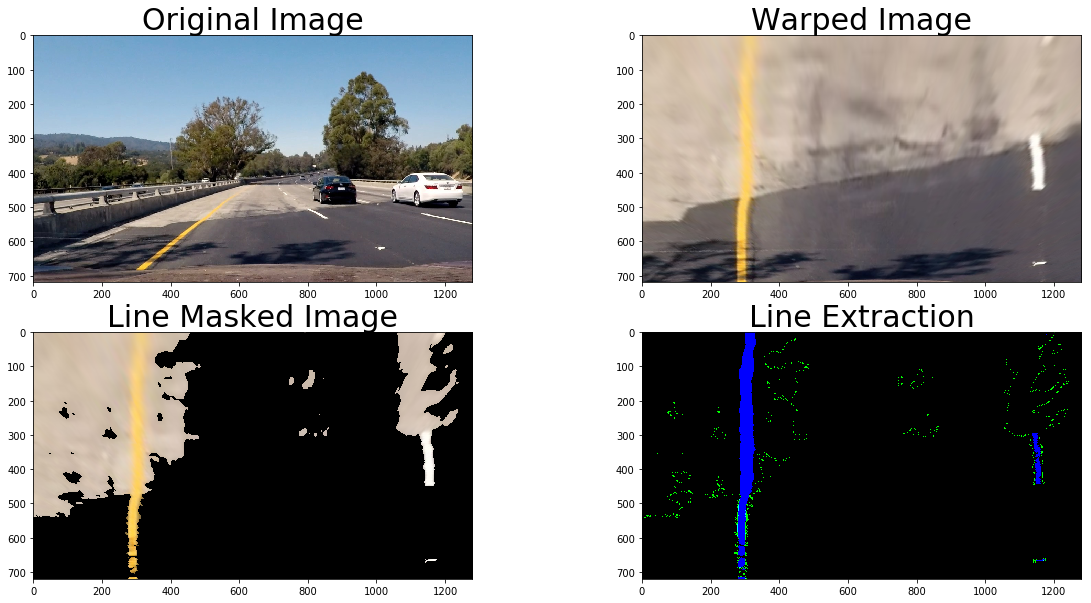

test5.jpg


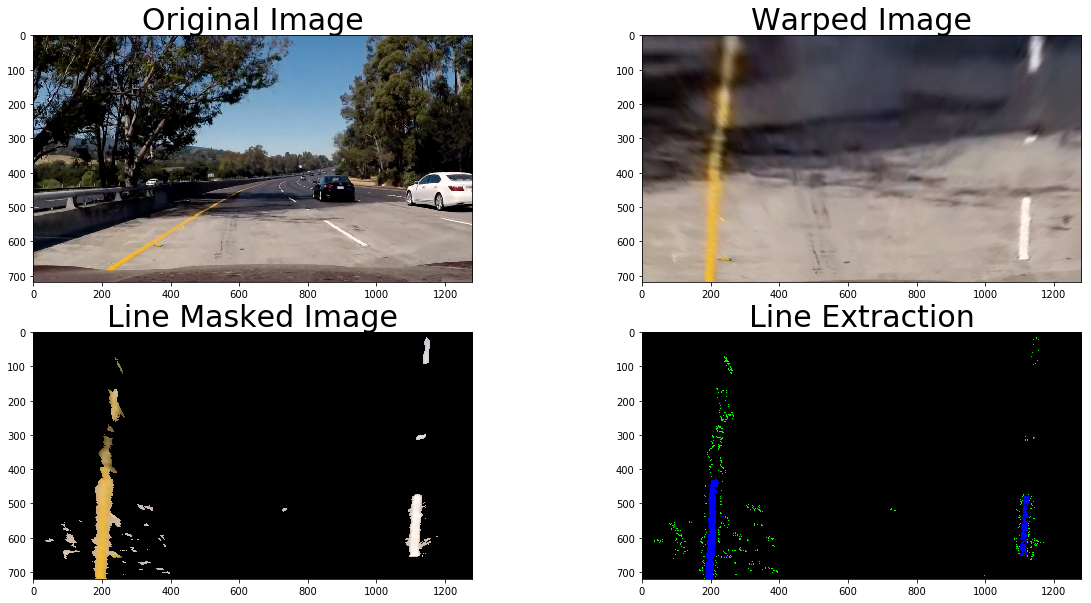

test6.jpg


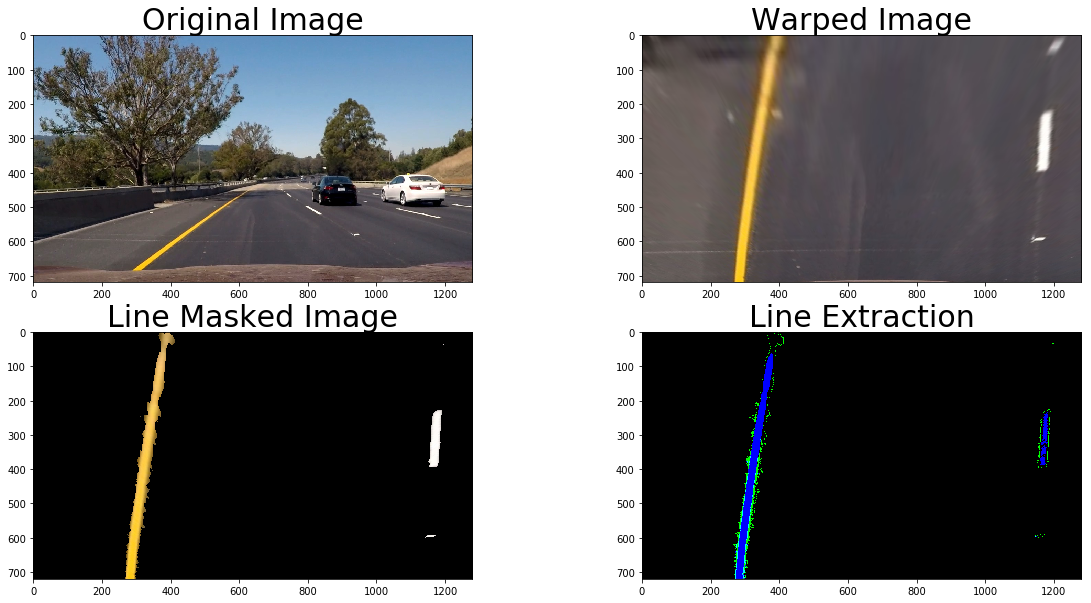

In [13]:
for image_name in os.listdir('test_images/'):
    print(image_name)
    
    img = mpimg.imread('test_images/' + image_name)
    warped_img = warp(img)
    masked_img = line_color_filter(warped_img)
    lines_img = lines_preprocessing(masked_img)
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped_img)
    ax2.set_title('Warped Image', fontsize=30)
    ax3.imshow(masked_img)
    ax3.set_title('Line Masked Image', fontsize=30)
    ax4.imshow(lines_img)
    ax4.set_title('Line Extraction', fontsize=30)
    plt.show()